# drlnd Project 1: Navigation

\
https://github.com/sliao-mi-luku/DeepRL-navigation-bananas-udacity-drlnd-p1/tree/master
\
\
Reinforcement learning environment by Unity ML-Agents

This corresponds to Project #1 of Udacity's Deep Reinforcement Learning Nanodegree (drlnd)\
https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893




## Box 1: Starting the environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import matplotlib.pyplot as plt

%matplotlib inline


from networkModels import Network
from buffer import Buffer
from dqnAgent import DQN_Agent


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("\nDevice: {}\n".format(device))




"""
env : use the path to Banana.exe
"""

env = UnityEnvironment(file_name = "./Banana_Windows_x86_64/Banana.exe")

"""
Environments contain brains which are responsible for deciding the actions of their associated agents.
Here we check for the first brain available, and set it as the default brain we will be controlling from Python.
"""

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


"""
states: 37 dimensions -  the agent's velocity, along with ray-based perception of objects around agent's forward direction

actions: 0 - walk forward
         1 - walk backward
         2 - turn left
         3 - turn right

rewards: +1 for collecting a yellow banana
         -1 for collecting a blue banana

"""

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)


print("\nBox 1 done!")


Device: cuda:0



INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37

Box 1 done!


## Box 2: Setting hyperparameters

In [2]:
EPISODES = 1000

UPDATE_EVERY = 5

PRINT_EVERY = 100

# hidden layers
hidden_sizes = [400, 300]

# discounting
gamma = 0.99

# Epsilon-Greedy
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995

# learning rate
lr = 5e-5

# soft update
tau = 1e-3

# buffer
buffer_size = int(1e5)
batch_size = 64

# seed
seed = 0

## Box 3: Deep Q-Learning

Episode 100	Score: 4.00	Avg: 0.72	Loss: 0.00112
Episode 200	Score: 4.00	Avg: 4.12	Loss: 0.00622
Episode 300	Score: 9.00	Avg: 6.83	Loss: 0.02007
Episode 400	Score: 12.00	Avg: 9.42	Loss: 0.0159
Episode 500	Score: 18.00	Avg: 13.03	Loss: 0.0436

Environemnt solved after 400 episodes	Avg score: 13.03


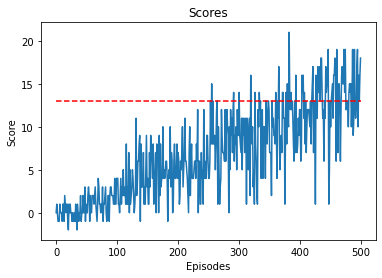

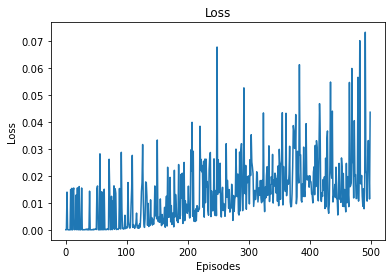


trained weights were saved


In [3]:
scores_history = []
scores_deque = deque(maxlen = 100)

loss_list = []

eps = eps_start # initial epsilon

agent = DQN_Agent(37, 4, hidden_sizes, seed, lr, gamma, tau)

buffer = Buffer(buffer_size, batch_size, seed)

for ep in range(1, EPISODES + 1):
    # reset the env
    env_info = env.reset(train_mode = True)[brain_name]
    state = env_info.vector_observations[0]
    
    score = 0
    
    t_step = 0

    while True:
        t_step += 1 
        state_t = torch.from_numpy(state).float().to(device)
        action = agent.act_eps(state_t, eps)
        env_info = env.step(int(action))[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        
        # add replay to buffer
        buffer.add(state, action, reward, next_state, done)
        
        if t_step % UPDATE_EVERY == 0 and len(buffer) >= batch_size:
            replays = buffer.sample()
            agent.learn(replays)

        state = next_state
        score += reward
        
        if done:
            break


    scores_history.append(score)
    scores_deque.append(score)
    
    loss_list.append(agent.loss)
    
    eps = max(eps*eps_decay, eps_end)
    
    avg_score = np.mean(scores_deque)

    print("\rEpisode {}\tScore: {:.2f}\tAvg: {:.2f}\tLoss: {:.4f}".format(ep, score, avg_score, agent.loss), end = "")

    if ep % PRINT_EVERY == 0:
        print("\rEpisode {}\tScore: {:.2f}\tAvg: {:.2f}\tLoss: {:.4f}".format(ep, score, avg_score, agent.loss))

    if np.mean(scores_deque) >= 13.0 and len(scores_deque) >= 100:
        print("\nEnvironemnt solved after {:d} episodes\tAvg score: {:.2f}".format(ep-100, avg_score))
        break

        
plt.figure()
plt.plot(np.arange(len(scores_history)), scores_history)
plt.plot([0, len(scores_history)-1], [13, 13], 'r--')
plt.title("Scores")
plt.xlabel("Episodes")
plt.ylabel("Score")

plt.figure()
plt.plot(np.arange(len(loss_list)), loss_list)
plt.title("Loss")
plt.xlabel("Episodes")
plt.ylabel("Loss")

plt.show()

torch.save(agent.local.state_dict(), 'local_weights.pth')
print("\ntrained weights were saved")

## Box 4: Loading trained weight

In [ ]:
### Watch a trained agent

agent = DQN_Agent(37, 4, hidden_sizes, seed, lr, gamma, tau)

agent.local.load_state_dict(torch.load('local_weights.pth'))
    
# reset the env
env_info = env.reset(train_mode = False)[brain_name]
state = env_info.vector_observations[0]
score = 0

while True:
    action = agent.act(torch.from_numpy(state).float().to(device))
    env_info = env.step(int(action))[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    state = next_state
    score += reward
    if done:
        break

print("Score: {}".format(score))
        

In [ ]:
env.close()